In [17]:
import pandas as pd
import requests
import os
from datetime import datetime
from data_creation import download_ecallisto_files, LOCAL_DATA_FOLDER
from glob import glob
from radiospectra.sources import CallistoSpectrogram
from spectogram_utils import spec_to_pd_dataframe, plot_spectogram, masked_spectogram_to_array
from database_utils import extract_instrument_name, glob_files, extract_constant_meta_data, extract_separate_instruments, create_dict_of_instrument_paths

In [18]:
download_ecallisto_files(dir=LOCAL_DATA_FOLDER, return_download_paths=False)

In [19]:
paths = glob_files(LOCAL_DATA_FOLDER, '**', '*', 'fit.gz')

In [20]:
dict_paths = create_dict_of_instrument_paths(paths)

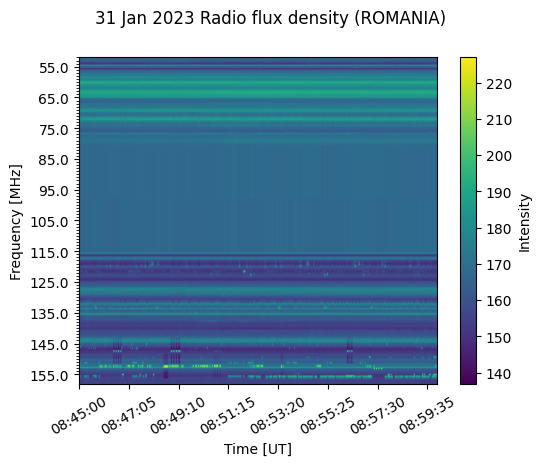

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [21]:
test = CallistoSpectrogram.read(dict_paths['romania_01'][2])
test.peek()

In [22]:
spec = masked_spectogram_to_array(test)

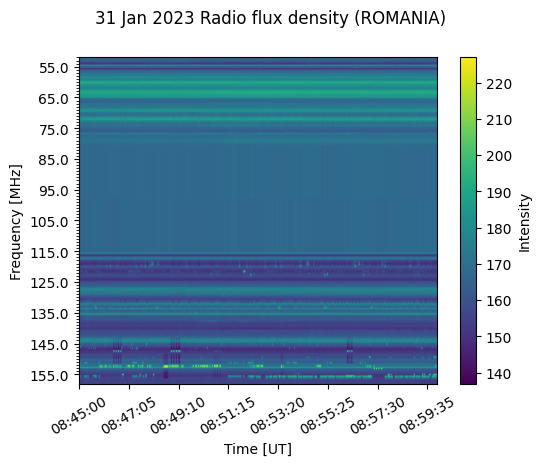

<AxesSubplot: xlabel='Time [UT]', ylabel='Frequency [MHz]'>

In [23]:
spec.peek()

In [24]:
download_ecallisto_files(instrument="all", dir = LOCAL_DATA_FOLDER)
paths = glob_files(LOCAL_DATA_FOLDER, '**', '*', 'fit.gz')
dict_paths = create_dict_of_instrument_paths(paths)

In [25]:
from database_functions import *
from database_utils import *
import numpy as np
from tqdm import tqdm

In [26]:
from spectogram_utils import spec_time_to_pd_datetime

In [35]:
date_range = spec_time_to_pd_datetime(spec)
test = np_array_to_postgresql_array_with_datetime_index(date_range, spec.data)

In [ ]:
# Sql query to select bottom 1000
query = """
SELECT * FROM romania_01
ORDER BY time DESC
LIMIT 1000  
"""

In [148]:
def add_values_to_database(dict_paths):
    """
    Adds the values from the given dictionary to the given dataframe
    """
    t = tqdm(dict_paths, total=len(dict_paths))
    for instrument in t:
        if instrument not in get_table_names_sql():
            spec = CallistoSpectrogram.read(dict_paths[instrument][0])
            spec = masked_spectogram_to_array(spec)
            sql_columns = numbers_list_to_postgresql_columns_meta_data(spec.freq_axis, 'SMALLINT')
            create_table_datetime_primary_key_sql(instrument, sql_columns, 'datetime')
            table_to_hyper_table(instrument, 'datetime')
        for path in dict_paths[instrument]:
            t.set_description(f"Currently adding {path.split('/')[-1]}")
            spec = CallistoSpectrogram.read(path)
            spec = masked_spectogram_to_array(spec)
            sql_columns = ",".join(number_list_to_postgresql_compatible_list(spec.freq_axis))
            sql_columns = 'datetime,' + sql_columns
            data = np.array(spec.data, dtype=np.int16)
            assert np.all(data <= 32767)
            date_range = spec_time_to_pd_datetime(spec)
            sql_values = np_array_to_postgresql_array_with_datetime_index(date_range, data)
            insert_values_sql(instrument, sql_columns, sql_values)

add_values_to_database(dict_paths)

Currently adding INDIA-OOTY_20230130_023000_02.fit.gz:   0%|          | 0/73 [00:42<?, ?it/s]